In [46]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
import math


In [47]:
par_swap_rates_bps = {
    '1Y': 117.45,
    '2Y': 120.60,
    '3Y': 133.03,
    '4Y': 152.05,
    '5Y': 171.85
}


In [48]:
strike_adjustments_bps = {'ATM-50': -50, 'ATM-25': -25, 'ATM-5': -5, 'ATM+5': 5, 'ATM+25': 25, 'ATM+50': 50}


In [49]:
volatility_table_decimal = {key: {inner_key: value / 10000 for inner_key, value in inner_dict.items()} for key, inner_dict in volatility_table.items()}

In [50]:
volatility_table = {
    'ATM-50': {'1Y': 58.31, '2Y': 51.72, '3Y': 46.29, '4Y': 45.72, '5Y': 44.92},
    'ATM-25': {'1Y': 51.51, '2Y': 46.87, '3Y': 44.48, '4Y': 41.80, '5Y': 40.61},
    'ATM-5':  {'1Y': 49.28, '2Y': 43.09, '3Y': 43.61, '4Y': 38.92, '5Y': 37.69},
    'ATM+5':  {'1Y': 48.74, '2Y': 42.63, '3Y': 39.36, '4Y': 38.19, '5Y': 36.94},
    'ATM+25': {'1Y': 41.46, '2Y': 38.23, '3Y': 35.95, '4Y': 34.41, '5Y': 33.36},
    'ATM+50': {'1Y': 37.33, '2Y': 34.55, '3Y': 32.55, '4Y': 31.15, '5Y': 30.21},
}


In [51]:
volatility_table_decimal = {expiry: {strike: vol / 10000 for strike, vol in strikes.items()} for expiry, strikes in volatility_table.items()}


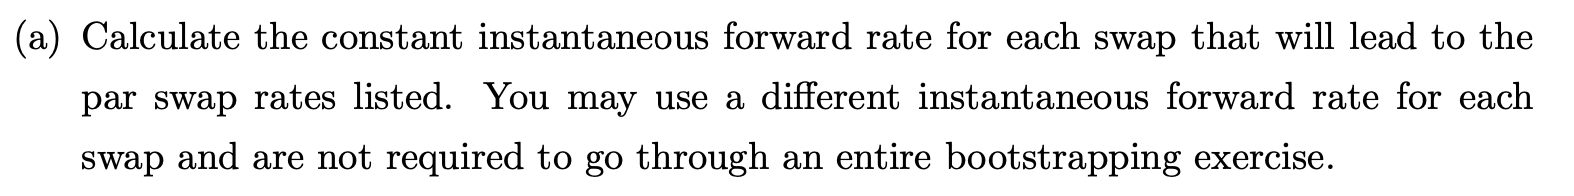

In [52]:
def approximate_forward_rate(F0, T):
    return -(1 / T) * math.log(F0 / 10000 / T)


In [53]:
T = 5  
forward_rates = {expiry: approximate_forward_rate(F0, T) for expiry, F0 in par_swap_rates_bps.items()}

forward_rates

{'1Y': 1.2107531146610724,
 '2Y': 1.2054598000234398,
 '3Y': 1.1858407235428938,
 '4Y': 1.159113774057382,
 '5Y': 1.134631256222888}

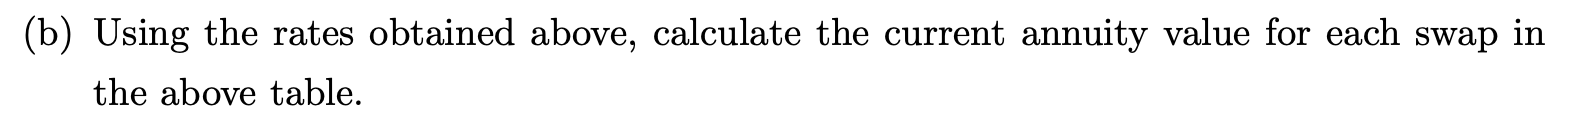

In [54]:
def annuity_value(C, r, T):
    return C * ((1 - math.exp(-r * T)) / r)


In [55]:
annuity_values = {expiry: annuity_value(par_swap_rates_bps[expiry] / 10000, rate, T) for expiry, rate in forward_rates.items()}

annuity_values

{'1Y': 0.009677787199647278,
 '2Y': 0.009980350468564828,
 '3Y': 0.01118835419866578,
 '4Y': 0.013077889275647212,
 '5Y': 0.01509383340276655}

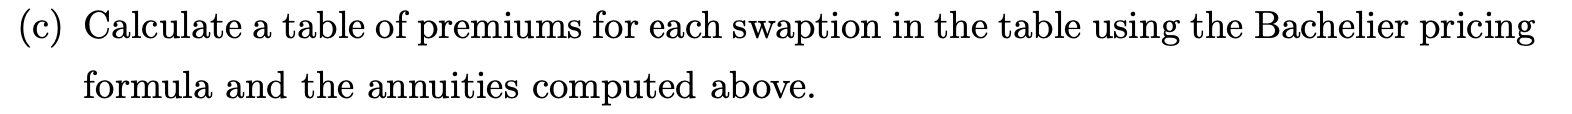

In [56]:
def calculate_premium(F, K, sigma, annuity, T):
    d = (F - K) / (sigma * math.sqrt(T))
    Phi_d = norm.cdf(d)  
    phi_d = norm.pdf(d) 
    premium = annuity * (F - K) * Phi_d + annuity * sigma * phi_d * math.sqrt(T)
    return premium

In [57]:
premiums_table = {}
for strike, volatilities in volatility_table_decimal.items():
    premiums_table[strike] = {}
    for expiry, volatility in volatilities.items():
        F = par_swap_rates_bps[expiry] / 10000
        adjustment = int(strike.replace('ATM', '')) if strike != 'ATM' else 0
        K = F + adjustment / 10000
        annuity = annuity_values[expiry]
        T = 5
        premium = calculate_premium(F, K, volatility, annuity, T)
        premiums_table[strike][expiry] = premium
for strike, premiums in premiums_table.items():
    print(f"Strike: {strike}")
    for expiry, premium in premiums.items():
        print(f"Expiry: {expiry}, Premium: {premium:.8f}")
    print()

Strike: ATM-50
Expiry: 1Y, Premium: 0.00007819
Expiry: 2Y, Premium: 0.00007524
Expiry: 3Y, Premium: 0.00007946
Expiry: 4Y, Premium: 0.00009229
Expiry: 5Y, Premium: 0.00010556

Strike: ATM-25
Expiry: 1Y, Premium: 0.00005761
Expiry: 2Y, Premium: 0.00005539
Expiry: 3Y, Premium: 0.00005977
Expiry: 4Y, Premium: 0.00006685
Expiry: 5Y, Premium: 0.00007561

Strike: ATM-5
Expiry: 1Y, Premium: 0.00004501
Expiry: 2Y, Premium: 0.00004091
Expiry: 3Y, Premium: 0.00004638
Expiry: 4Y, Premium: 0.00004875
Expiry: 5Y, Premium: 0.00005461

Strike: ATM+5
Expiry: 1Y, Premium: 0.00003970
Expiry: 2Y, Premium: 0.00003551
Expiry: 3Y, Premium: 0.00003655
Expiry: 4Y, Premium: 0.00004136
Expiry: 5Y, Premium: 0.00004606

Strike: ATM+25
Expiry: 1Y, Premium: 0.00002499
Expiry: 2Y, Premium: 0.00002301
Expiry: 3Y, Premium: 0.00002362
Expiry: 4Y, Premium: 0.00002590
Expiry: 5Y, Premium: 0.00002855

Strike: ATM+50
Expiry: 1Y, Premium: 0.00001365
Expiry: 2Y, Premium: 0.00001204
Expiry: 3Y, Premium: 0.00001189
Expiry: 4Y,

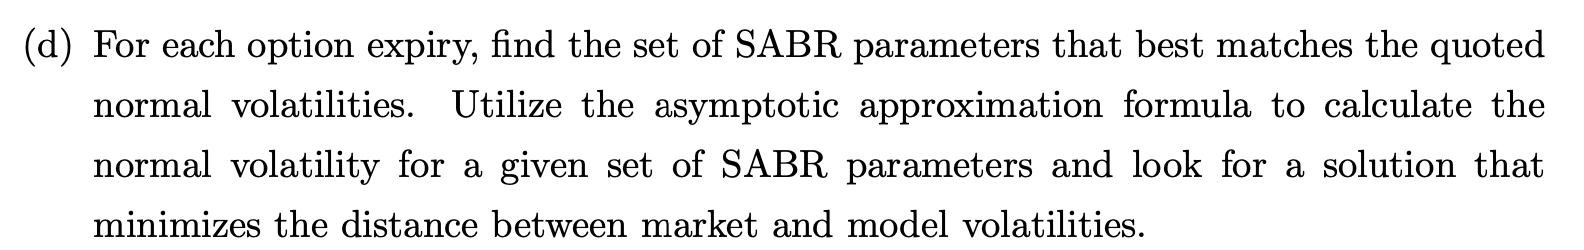

In [73]:
def sabr_volatility(F, K, alpha, beta, rho, nu, T):
    FK_beta = ((F * K) ** ((1 - beta) / 2))

    z = (nu / alpha) * FK_beta * np.log(F / K)
    x_z = np.log((math.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    
    term1 = ((1 - beta) ** 2 / 24) * (math.log(F / K) ** 2)
    term2 = ((1 - beta) ** 4 / 1920) * (math.log(F / K) ** 4)
    A = alpha / (FK_beta * (1 + term1 + term2))
    
    term3 = ((1 - beta) ** 2 / 24) * (alpha ** 2 / (FK_beta ** 2))
    term4 = 0.25 * rho * beta * nu * alpha / FK_beta
    term5 = (2 - 3 * rho ** 2) * (nu ** 2 / 24)
    B = 1 + (term3 + term4 + term5) * T
    
    sigma_sabr = A * B * z / x_z
    
    return sigma_sabr

In [74]:
def objective_function(params, F, market_vols, strikes, T):
    alpha, rho, nu = params
    beta = 0.5  
    errors = []
    for market_vol, K in zip(market_vols, strikes):
        model_vol = sabr_volatility(F, K, alpha, beta, rho, nu, T)
        errors.append((model_vol - market_vol) ** 2)
    return sum(errors)

In [94]:
forward_rates_bps = {
    '1Y': 117.45,
    '2Y': 120.60,
    '3Y': 133.03,
    '4Y': 152.05,
    '5Y': 171.85
}

forward_rates = {expiry: rate / 10000 for expiry, rate in forward_rates_bps.items()}
forward_rates

{'1Y': 0.011745,
 '2Y': 0.01206,
 '3Y': 0.013303,
 '4Y': 0.015205000000000002,
 '5Y': 0.017185}

In [95]:
market_vol = []
strikes = []
expiries = []

for expiry, strikes_volatilities in volatility_table_decimal.items():
    F0 = forward_rates[expiry]
    for strike_category, volatility in strikes_volatilities.items():
        strike_adj = strike_adjustments_bps[strike_category]
        market_vol.append(volatility)
        strikes.append(F0 + strike_adj / 10000)
        expiries.append(int(expiry[0])) 
        
market_vol = np.array(market_vol)
strikes = np.array(strikes)
expiries = np.array(expiries)


In [96]:
initial_params = [0.001, 0, 0.005]  

bounds = [(1e-4, None), (-1, 1), (1e-4, None)]

optimized_params_by_expiry = {}

for expiry in np.unique(expiries):
    mask = expiries == expiry
    F = forward_rates[f'{expiry}Y']
    market_vols_for_expiry = market_vols[mask]
    strikes_for_expiry = strikes[mask]
    T = expiry

    minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds, "args": (F, market_vols_for_expiry, strikes_for_expiry, T)}

    result = basinhopping(objective_function, initial_params, minimizer_kwargs=minimizer_kwargs,
                          niter=100, stepsize=0.01, niter_success=10)

    optimized_params_by_expiry[expiry] = result.x

for expiry, params in optimized_params_by_expiry.items():
    alpha_opt, rho_opt, nu_opt = params
    print(f"Optimized parameters for expiry {expiry}: alpha={alpha_opt}, rho={rho_opt}, nu={nu_opt}")


Optimized parameters for expiry 1: alpha=0.0005138893950280077, rho=0.025081909419987045, nu=0.00010009257362525204
Optimized parameters for expiry 2: alpha=0.0004646258494479013, rho=-0.003442611772824042, nu=0.0026500322136617026
Optimized parameters for expiry 3: alpha=0.0004628014267054994, rho=-0.009214146405546008, nu=0.0001001145873709281
Optimized parameters for expiry 4: alpha=0.00046592359809742676, rho=1.7571738725525056e-06, nu=0.004695872178271364
Optimized parameters for expiry 5: alpha=0.0004826500319185997, rho=-0.006517775981667857, nu=0.004970450629034117


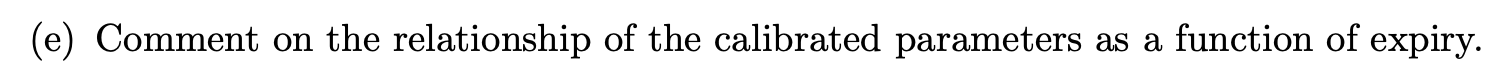

In [97]:
def find_sse(alpha, rho, nu, beta, F, market_vols, strikes, T):
    # error calculation
    sse = 0.0
    for K, market_vol in zip(strikes, market_vols):
        model_vol = sabr_volatility(F, K, alpha, beta, rho, nu, T)
        sse += (model_vol - market_vol) ** 2
    return sse

def plot_volatility_smile(alpha, rho, nu, beta, F, market_vols, strikes, T):
    model_vols = [sabr_volatility(F, K, alpha, beta, rho, nu, T) for K in strikes]
    
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, model_vols, 'o-', label='SABR Model Volatilities')
    plt.plot(strikes, market_vols, 'o-', label='Market Volatilities')
    plt.title(f'SABR Model Volatility Smile - Expiry: {T} years')
    plt.xlabel('Strike Price')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


The SSE of calculating expiry Year 1: 7.261339966582223e-07


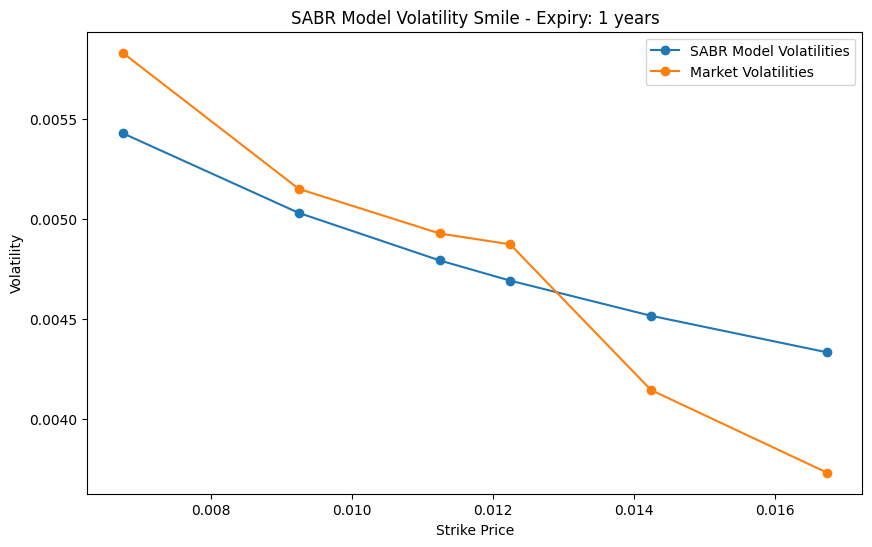

The SSE of calculating expiry Year 2: 3.7594197148591513e-07


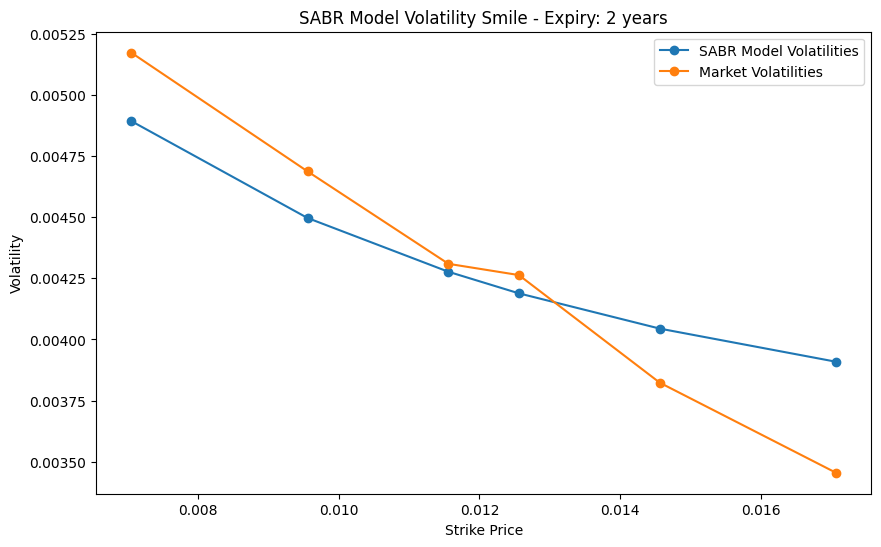

The SSE of calculating expiry Year 3: 4.227608128656224e-07


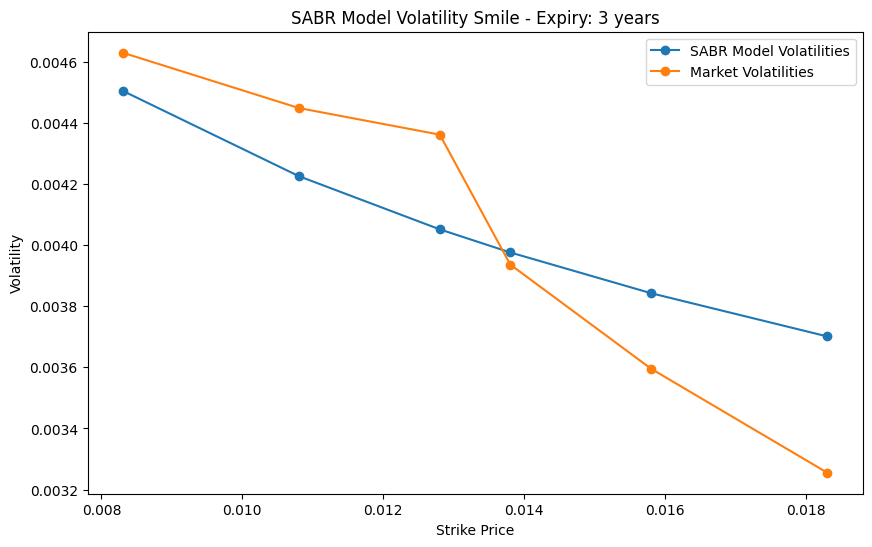

The SSE of calculating expiry Year 4: 4.057279421765944e-07


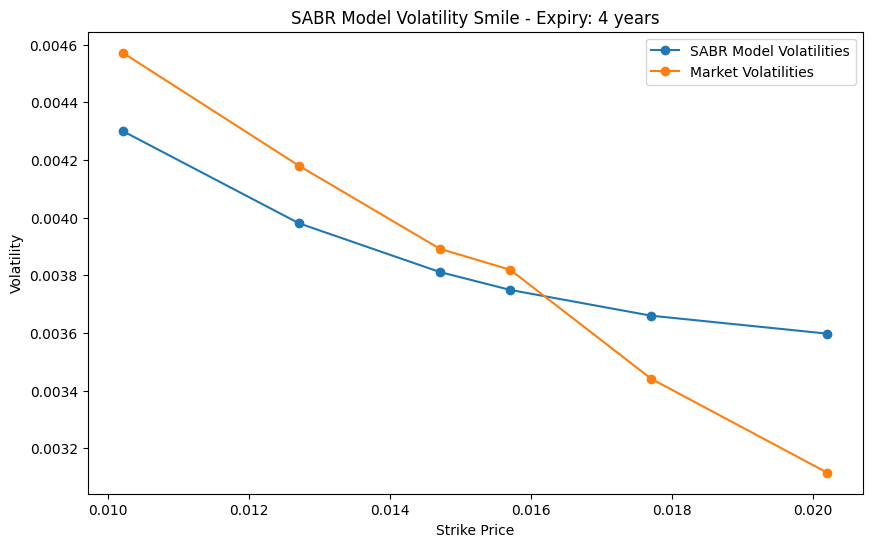

The SSE of calculating expiry Year 5: 4.888029196494676e-07


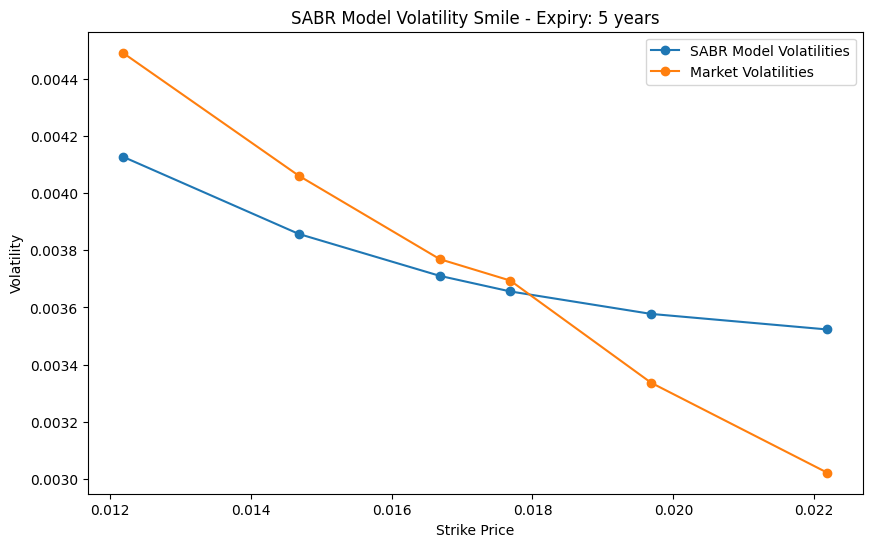

In [98]:
for expiry, params in optimized_params_by_expiry.items():
    alpha, rho, nu = params
    beta = 0.5  # Assuming beta was fixed 

    mask = expiries == expiry
    F = forward_rates[f'{expiry}Y'] 
    market_vols_for_expiry = market_vols[mask]
    strikes_for_expiry = strikes[mask]

    sse = find_sse(alpha, rho, nu, beta, F, market_vols_for_expiry, strikes_for_expiry, expiry)
    print(f"The SSE of calculating expiry Year {expiry}: {sse}")
    
    plot_volatility_smile(alpha, rho, nu, beta, F, market_vols_for_expiry, strikes_for_expiry, expiry)


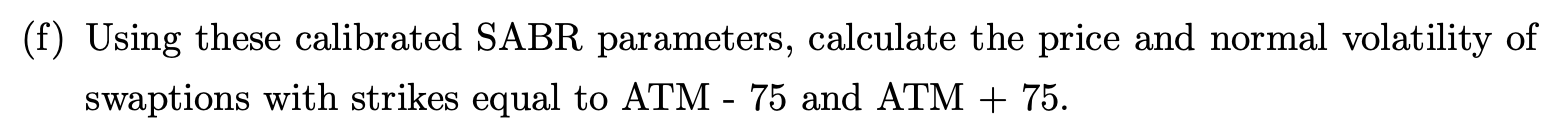

In [99]:
optimized_params_by_expiry

{1: array([0.00051389, 0.02508191, 0.00010009]),
 2: array([ 0.00046463, -0.00344261,  0.00265003]),
 3: array([ 0.0004628 , -0.00921415,  0.00010011]),
 4: array([4.65923598e-04, 1.75717387e-06, 4.69587218e-03]),
 5: array([ 0.00048265, -0.00651778,  0.00497045])}

In [101]:
forward_rates = {
    1: 0.011745,
    2: 0.012060,
    3: 0.013303,
    4: 0.015205,
    5: 0.017185,
}

In [111]:
beta = 0.5 

adjusted_strikes_bps = {'ATM-75': -75, 'ATM+75': 75}
for expiry, params in optimized_params_by_expiry.items():
    F = forward_rates[expiry]
    alpha, rho, nu = params
    print(f"\nExpiry: {expiry} year")
    for label, adj_bps in adjusted_strikes_bps.items():
        K_adj = F + adj_bps / 10000
        implied_vol = sabr_volatility(F, K_adj, alpha, beta, rho, nu, expiry)
        print(f"{label}: Implied Volatility = {implied_vol:.4f}")


Expiry: 1 year
ATM-75: Implied Volatility = 0.0060
ATM+75: Implied Volatility = 0.0042

Expiry: 2 year
ATM-75: Implied Volatility = 0.0055
ATM+75: Implied Volatility = 0.0038

Expiry: 3 year
ATM-75: Implied Volatility = 0.0049
ATM+75: Implied Volatility = 0.0036

Expiry: 4 year
ATM-75: Implied Volatility = 0.0048
ATM+75: Implied Volatility = 0.0036

Expiry: 5 year
ATM-75: Implied Volatility = 0.0045
ATM+75: Implied Volatility = 0.0035


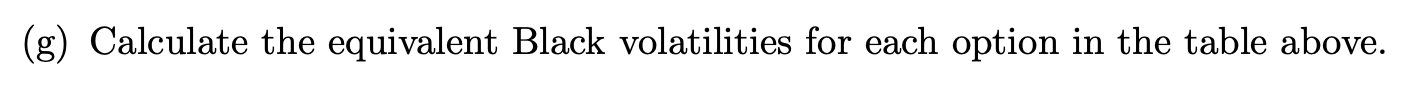

In [103]:
black_volatilities = {expiry: {} for expiry in forward_rates_bps.keys()}

def normal_to_black_volatility(F0, normal_vol, K, T):
    d1 = (F0 - K) / (normal_vol * np.sqrt(T))
    black_vol = normal_vol / (F0 * norm.pdf(d1))
    return black_vol

for expiry, vol_dict in volatility_table_decimal.items():
    for strike_category, normal_vol in vol_dict.items():
        expiry_key = int(expiry[:-1])  
        F0 = forward_rates[expiry_key]
        if 'ATM' in strike_category:
            K = F0
        else:
            adjustment = int(strike_category.split('ATM')[1])
            K = F0 + adjustment / 10000
        black_vol = normal_to_black_volatility(F0, normal_vol, K, int(expiry[0]))
        black_volatilities[expiry][strike_category] = black_vol

for expiry, strikes_dict in black_volatilities.items():
    print(f"Expiry: {expiry}")
    for strike_category, black_vol in strikes_dict.items():
        print(f"  {strike_category}: {black_vol:.4f}")

Expiry: 1Y
  ATM-50: 1.2445
  ATM-25: 1.0993
  ATM-5: 1.0517
  ATM+5: 1.0402
  ATM+25: 0.8848
  ATM+50: 0.7967
Expiry: 2Y
  ATM-50: 1.0750
  ATM-25: 0.9742
  ATM-5: 0.8956
  ATM+5: 0.8860
  ATM+25: 0.7946
  ATM+50: 0.7181
Expiry: 3Y
  ATM-50: 0.8722
  ATM-25: 0.8381
  ATM-5: 0.8217
  ATM+5: 0.7416
  ATM+25: 0.6774
  ATM+50: 0.6133
Expiry: 4Y
  ATM-50: 0.7537
  ATM-25: 0.6891
  ATM-5: 0.6416
  ATM+5: 0.6296
  ATM+25: 0.5673
  ATM+50: 0.5135
Expiry: 5Y
  ATM-50: 0.6552
  ATM-25: 0.5923
  ATM-5: 0.5498
  ATM+5: 0.5388
  ATM+25: 0.4866
  ATM+50: 0.4406


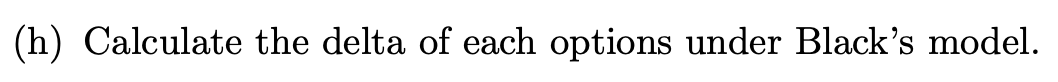

In [104]:
def calculate_annuity(r, T):
    return (1 - np.exp(-r * T)) / r

def black_delta(F, K, sigma, T, r, is_payer=True):
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    annuity = calculate_annuity(r, T)
    if is_payer:
        delta = annuity * norm.cdf(d1)
    else:
        delta = -annuity * norm.cdf(-d1)
    return delta

r = 0.01  
expiries = [1, 2, 3, 4, 5] 
strikes_bps = {'ATM-50': -50, 'ATM-25': -25, 'ATM-5': -5, 'ATM+5': 5, 'ATM+25': 25, 'ATM+50': 50} 

delta_results = {}
for expiry in expiries:
    F0 = forward_rates_bps[str(expiry) + 'Y'] / 10000  
    deltas = {}
    for strike_label, adjustment_bps in strikes_bps.items():
        K = F0 + adjustment_bps / 10000  
        sigma = volatility_table_decimal[str(expiry) + 'Y'][strike_label] / 10000  
        delta_payer = black_delta(F0, K, sigma, expiry, r, is_payer=True)
        delta_receiver = black_delta(F0, K, sigma, expiry, r, is_payer=False)
        deltas[strike_label] = {'Payer': delta_payer, 'Receiver': delta_receiver}
    delta_results[str(expiry) + 'Y'] = deltas

for expiry, deltas in delta_results.items():
    print(f"Expiry: {expiry}")
    for strike_label, delta_values in deltas.items():
        print(f"  Strike {strike_label}: Payer Delta = {delta_values['Payer']}, Receiver Delta = {delta_values['Receiver']}")


Expiry: 1Y
  Strike ATM-50: Payer Delta = 0.9950166250831893, Receiver Delta = -0.0
  Strike ATM-25: Payer Delta = 0.9950166250831893, Receiver Delta = -0.0
  Strike ATM-5: Payer Delta = 0.9950166250831893, Receiver Delta = -0.0
  Strike ATM+5: Payer Delta = 0.0, Receiver Delta = -0.9950166250831893
  Strike ATM+25: Payer Delta = 0.0, Receiver Delta = -0.9950166250831893
  Strike ATM+50: Payer Delta = 0.0, Receiver Delta = -0.9950166250831893
Expiry: 2Y
  Strike ATM-50: Payer Delta = 1.9801326693244747, Receiver Delta = -0.0
  Strike ATM-25: Payer Delta = 1.9801326693244747, Receiver Delta = -0.0
  Strike ATM-5: Payer Delta = 1.9801326693244747, Receiver Delta = -0.0
  Strike ATM+5: Payer Delta = 0.0, Receiver Delta = -1.9801326693244747
  Strike ATM+25: Payer Delta = 0.0, Receiver Delta = -1.9801326693244747
  Strike ATM+50: Payer Delta = 0.0, Receiver Delta = -1.9801326693244747
Expiry: 3Y
  Strike ATM-50: Payer Delta = 2.9554466451491845, Receiver Delta = -0.0
  Strike ATM-25: Payer

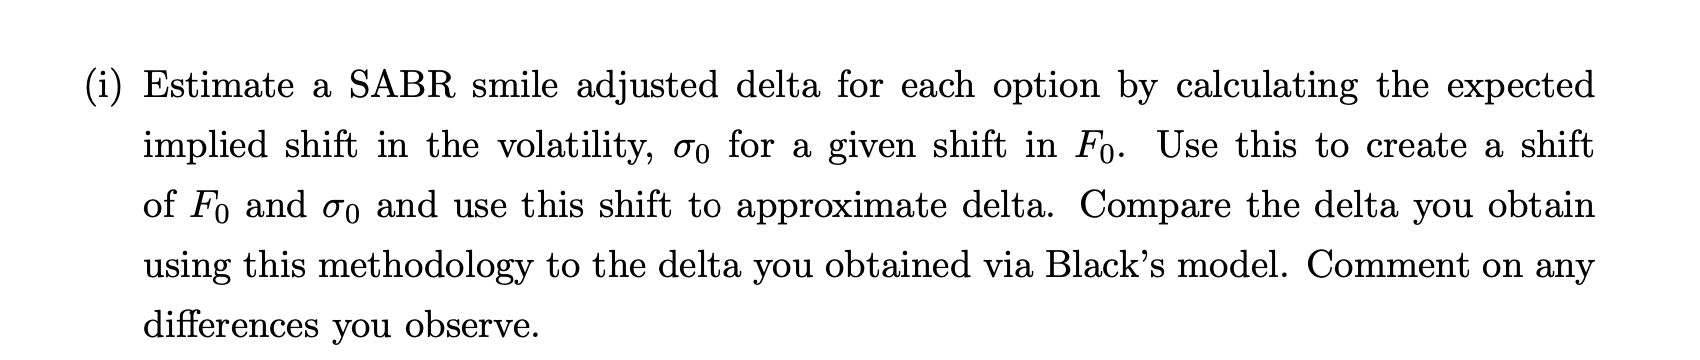

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'ellipsis'

In [108]:
adjusted_delta = sabr_smile_adjusted_delta(alpha, rho, nu, F, K, T, r)


TypeError: sabr_smile_adjusted_delta() missing 2 required positional arguments: 'annuity' and 'r'